In [99]:
import sys
sys.path.append("..")

from libs.InteractivePitchUI import *
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *
from libs.alpha_shape import *
from libs.weight_generator import *
from libs.similar_movement import *

In [100]:
inverse_weighting_preds_sit_2 = pd.read_csv("Inverse_functionDenmark_England_2766.0/Inverse_functionDenmark_England_2766.0_ground_truth.csv")
linear_weighting_preds_sit_2 = pd.read_csv("Linear_functionDenmark_England_2766.0/Linear_functionDenmark_England_2766.0_ground_truth.csv")
exp_weighting_preds_sit_2 = pd.read_csv("Exp_functionDenmark_England_2766.0/Exp_functionDenmark_England_2766.0_ground_truth.csv")
control_preds_sit_2 = pd.read_csv("Control_functionDenmark_England_2766.0/Control_functionDenmark_England_2766.0_ground_truth.csv")

inverse_weighting_preds_sit_1 = pd.read_csv("Inverse_functionDenmark_Serbia_1038.0/Inverse_functionDenmark_Serbia_1038.0_ground_truth.csv")
linear_weighting_preds_sit_1 = pd.read_csv("Linear_functionDenmark_Serbia_1038.0/Linear_functionDenmark_Serbia_1038.0_ground_truth.csv")
exp_weighting_preds_sit_1 = pd.read_csv("Exp_functionDenmark_Serbia_1038.0/Exp_functionDenmark_Serbia_1038.0_ground_truth.csv")
control_preds_sit_1 = pd.read_csv("Control_functionDenmark_Serbia_1038.0/Control_functionDenmark_Serbia_1038.0_ground_truth.csv")

In [101]:
rated_situations_2 = pd.read_csv("situations_scores_2.csv")
rated_situations_2["Unnamed: 0"] = rated_situations_2["Unnamed: 0"].apply(lambda x: int(x))

In [102]:
rated_situations_1 = pd.read_csv("situations_scores_indexed.csv")
rated_situations_1["Unnamed: 0"] = rated_situations_1["Unnamed: 0"].apply(lambda x: int(x))

In [103]:
print(rated_situations_1.head())
print(inverse_weighting_preds_sit_1.head())

   Unnamed: 0       match_name  score
0      286416   Denmark_Serbia      3
1      296880   Denmark_Serbia      0
2      340848   Denmark_Serbia      0
3      353712   Denmark_Serbia      0
4      149808  Denmark_England      3
   Unnamed: 0        match_name        Time [s]
0      497424   Germany_Denmark         1:10:14
1      286416    Denmark_Serbia  0:01:10.080000
2      296880    Denmark_Serbia  0:08:08.640000
3      149808   Denmark_England  0:04:20.440000
4       27312  Slovenia_Denmark  0:18:12.480000


In [104]:

# Merge on the 'Unnamed: 0' column
inv_sit_2_results = pd.merge(inverse_weighting_preds_sit_2, rated_situations_2, on='Unnamed: 0', how='inner')
lin_sit_2_results = pd.merge(linear_weighting_preds_sit_2, rated_situations_2, on='Unnamed: 0', how='inner')
control_sit_2_results = pd.merge(control_preds_sit_2, rated_situations_2, on='Unnamed: 0', how='inner')
exp_sit_2_results = pd.merge(exp_weighting_preds_sit_2, rated_situations_2, on='Unnamed: 0', how='inner')




In [105]:
# Merge on the 'Unnamed: 0' column
inv_sit_1_results = pd.merge(inverse_weighting_preds_sit_1, rated_situations_1, on='Unnamed: 0', how='inner')
lin_sit_1_results = pd.merge(linear_weighting_preds_sit_1, rated_situations_1, on='Unnamed: 0', how='inner')
control_sit_1_results = pd.merge(control_preds_sit_1, rated_situations_1, on='Unnamed: 0', how='inner')
exp_sit_1_results = pd.merge(exp_weighting_preds_sit_1, rated_situations_1, on='Unnamed: 0', how='inner')



In [106]:
inv_sit_1_results.head()

,Unnamed: 0,match_name_x,Time [s],match_name_y,score
0,497424,Germany_Denmark,1:10:14,Germany_Denmark,0
1,286416,Denmark_Serbia,0:01:10.080000,Denmark_Serbia,3
2,296880,Denmark_Serbia,0:08:08.640000,Denmark_Serbia,0
3,149808,Denmark_England,0:04:20.440000,Denmark_England,3
4,27312,Slovenia_Denmark,0:18:12.480000,Slovenia_Denmark,0


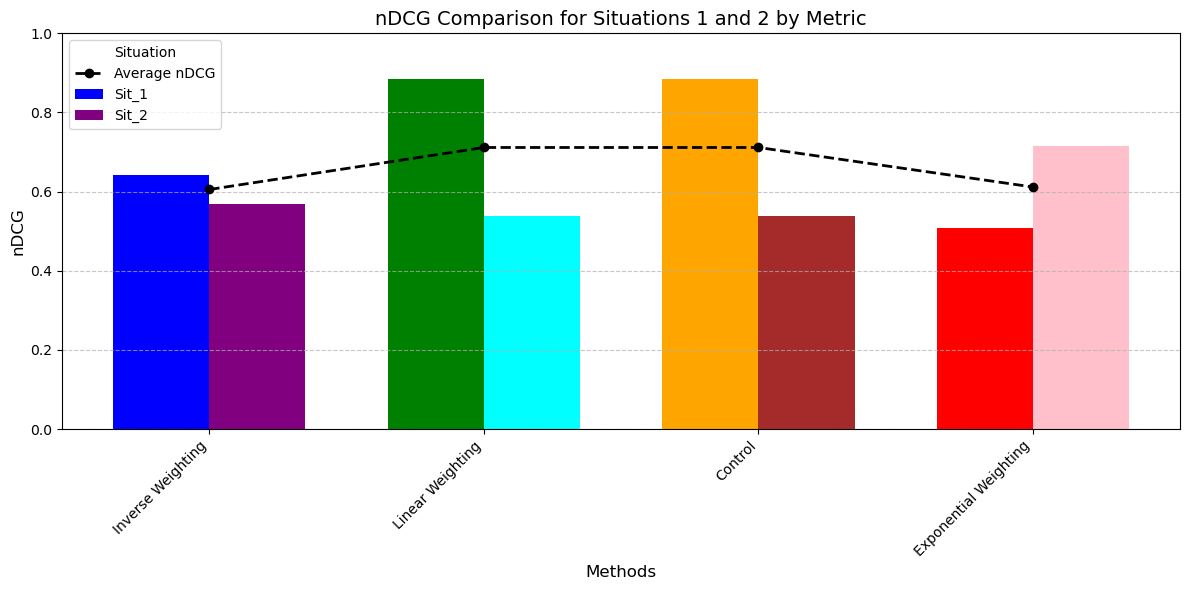

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to calculate nDCG
def calculate_ndcg(df, score_column, k=None):
    if k is None:
        k = len(df)

    # Extract relevance scores
    scores = df[score_column].values[:k]

    # Compute DCG
    dcg = np.sum((2**scores - 1) / np.log2(np.arange(2, k + 2)))

    # Compute IDCG (ideal DCG)
    sorted_scores = np.sort(scores)[::-1]
    idcg = np.sum((2**sorted_scores - 1) / np.log2(np.arange(2, k + 2)))

    # Return nDCG
    return dcg / idcg if idcg > 0 else 0.0

# Situation 1 methods nDCG calculation
methods_sit_1 = {
    "Inverse Weighting": inv_sit_1_results,
    "Linear Weighting": lin_sit_1_results,
    "Control": control_sit_1_results,
    "Exponential Weighting": exp_sit_1_results
}
ndcg_scores_sit_1 = {method: calculate_ndcg(df, score_column="score") for method, df in methods_sit_1.items()}

# Situation 2 methods nDCG calculation
methods_sit_2 = {
    "Inverse Weighting": inv_sit_2_results,
    "Linear Weighting": lin_sit_2_results,
    "Control": control_sit_2_results,
    "Exponential Weighting": exp_sit_2_results
}
ndcg_scores_sit_2 = {method: calculate_ndcg(df, score_column="score") for method, df in methods_sit_2.items()}

# Combine the nDCG scores for both situations into a single list
methods = list(ndcg_scores_sit_1.keys())  # Assuming both situations have the same methods
ndcg_sit_1_values = list(ndcg_scores_sit_1.values())
ndcg_sit_2_values = list(ndcg_scores_sit_2.values())

# Calculate the average nDCG for each metric
average_ndcg = [(ndcg_sit_1_values[i] + ndcg_sit_2_values[i]) / 2 for i in range(len(methods))]

# Define positions for the bars, grouped by method
n_methods = len(methods)
group_width = 0.35  # width of each group (bar width)
x_pos = np.arange(n_methods)  # Positions for the bars on the x-axis

# Plot the nDCG scores for both situations grouped by metric
plt.figure(figsize=(12, 6))
plt.bar(x_pos - group_width / 2, ndcg_sit_1_values, width=group_width, label="Sit_1", color=['blue', 'green', 'orange', 'red'])
plt.bar(x_pos + group_width / 2, ndcg_sit_2_values, width=group_width, label="Sit_2", color=['purple', 'cyan', 'brown', 'pink'])

# Plot the average nDCG as a marker or line
plt.plot(x_pos, average_ndcg, color='black', marker='o', linestyle='--', label="Average nDCG", linewidth=2)

# Add labels, title, and customize axes
plt.title("nDCG Comparison for Situations 1 and 2 by Metric", fontsize=14)
plt.ylabel("nDCG", fontsize=12)
plt.xlabel("Methods", fontsize=12)
plt.ylim(0, 1)  # nDCG ranges from 0 to 1

# Customizing tick positions and labels
plt.xticks(x_pos, methods, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Situation", loc='upper left')
plt.tight_layout()  # Ensure the labels fit well
plt.show()
